### Descrição Geral do Projeto

Neste notebook, realizamos uma análise completa de um dataset de produtos agrícolas com o objetivo de entender as condições ideais para o cultivo de diferentes safras e desenvolver modelos preditivos para classificar a cultura com base nessas condições. As principais etapas realizadas foram:

1.  **Carga e Inspeção dos Dados:** Iniciamos carregando o dataset `produtos_agricolas.csv` e realizando uma inspeção inicial para entender a estrutura dos dados, tipos de variáveis e identificar a presença de valores faltantes.

2.  **Limpeza dos Dados:** Para lidar com os valores faltantes identificados, optamos por preencher os dados ausentes em cada coluna numérica com a média da respectiva coluna.

3.  **Análise Exploratória de Dados (EDA):** Realizamos uma análise exploratória aprofundada com a criação de diversos gráficos, incluindo:
    *   Histogramas para visualizar a distribuição de cada feature numérica.
    *   Um gráfico de contagem para verificar a distribuição das diferentes culturas ('label').
    *   Um pairplot para explorar as relações entre todas as features numéricas, diferenciando por cultura.
    *   Gráficos de violino para visualizar a distribuição das features numéricas para cada cultura.
    *   Boxplots para identificar outliers e a distribuição das features numéricas por cultura.
    *   Uma matriz de correlação para entender a relação entre as features numéricas.

4.  **Identificação das Condições Ideais para as Culturas:** Agrupamos os dados por cultura ('label') e calculamos estatísticas descritivas (média, mediana, desvio padrão, etc.) para as features numéricas. Isso nos permitiu ter uma ideia do "perfil ideal" de solo e clima associado a cada cultura presente no dataset.

5.  **Preparação dos Dados para Modelagem:** Preparamos os dados para o treinamento dos modelos preditivos. Esta etapa incluiu:
    *   Separar as features (variáveis independentes) da variável alvo ('label').
    *   Codificar a variável alvo categórica ('label') em valores numéricos usando `LabelEncoder`.
    *   Dividir o dataset em conjuntos de treinamento e teste para avaliar o desempenho dos modelos em dados não vistos.
    *   Normalizar as features numéricas usando `MinMaxScaler` para garantir que todas as features tenham a mesma escala, o que é importante para o desempenho de alguns algoritmos.

6.  **Desenvolvimento e Avaliação de Modelos Preditivos:** Treinamos 5 modelos de classificação diferentes para prever a cultura com base nas features de solo e clima:
    *   K-Nearest Neighbors
    *   Regressão Logística
    *   Support Vector Machine
    *   Decision Tree
    *   Random Forest

    Para cada modelo, calculamos a acurácia e geramos um relatório de classificação para avaliar métricas como precisão, recall e F1-score.

7.  **Avaliação Comparativa dos Modelos:** Comparamos o desempenho dos 5 modelos treinados. Apresentamos as acurácias de cada modelo e visualizamos essa comparação em um gráfico de barras. Além disso, geramos as Curvas ROC (Macro-Average) para uma comparação visual mais aprofundada da capacidade de discriminação de cada modelo.

Com base na acurácia e nas Curvas ROC, o modelo **Random Forest** demonstrou ser o mais eficaz para a tarefa de classificação neste dataset.

In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
# Carregar o dataset
df = pd.read_csv("produtos_agricolas.csv")
# Pegando um amostra de 5 linha aleatorias
df.sample(5)

,N,P,K,temperature,humidity,ph,rainfall,label
1674,20,8,12,25.299043,94.964199,7.260416,117.973342,orange
2022,84,55,38,26.874839,79.787252,6.956683,173.101710,jute
1113,11,27,30,27.696378,48.562249,6.394743,89.856465,mango
1408,113,6,52,27.763172,90.355676,6.740984,25.216091,muskmelon
1424,102,25,50,28.204808,92.914404,6.099662,20.360011,muskmelon


In [3]:
# Traduzir as labels do dataframe usando o ChatGPT API
from openai import OpenAI
from google.colab import userdata

# Configure o OpenAI API
# Certifique-se de ter sua chave de API do OpenAI armazenada nos segredos do Colab com o nome 'OPENAI_API_KEY'
try:
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
    client = OpenAI(api_key=OPENAI_API_KEY)
except Exception as e:
    print(f"Erro ao configurar o OpenAI API: {e}")
    print("Por favor, verifique se sua chave de API do OpenAI está armazenada nos segredos do Colab com o nome 'OPENAI_API_KEY'.")
    client = None # Set client to None if initialization fails


if client:
    # Obter labels únicas
    unique_labels = df['label'].unique()
    translated_labels = {}

    print("Traduzindo labels...")
    for label in unique_labels:
        try:
            completion = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": f"traduza para o portugues {label}, apenas a tradução."}
                ]
            )
            translated_labels[label] = completion.choices[0].message.content.strip().lower() # Convert to lowercase for consistency
            print(f"'{label}' traduzido para '{translated_labels[label]}'")
        except Exception as e:
            print(f"Erro ao traduzir '{label}': {e}")
            translated_labels[label] = label

    df['label'] = df['label'].map(translated_labels)

    print("\nLabels traduzidas e dataframe atualizado.")
    display(df.sample(5))
else:
    print("\nTradução não realizada devido a erro na configuração do OpenAI API.")

Traduzindo labels...
'rice' traduzido para 'arroz'
'maize' traduzido para 'milho'
'chickpea' traduzido para 'grão-de-bico'
'kidneybeans' traduzido para 'feijão vermelho'
'pigeonpeas' traduzido para 'feijão-guandu'
'mothbeans' traduzido para 'feijão da mariposa'
'mungbean' traduzido para 'feijão mungo'
'blackgram' traduzido para 'feijão preto'
'lentil' traduzido para 'lentilha'
'pomegranate' traduzido para 'romã'
'banana' traduzido para 'banana'
'mango' traduzido para 'manga'
'grapes' traduzido para 'uvas'
'watermelon' traduzido para 'melancia'
'muskmelon' traduzido para 'melão'
'apple' traduzido para 'maçã'
'orange' traduzido para 'laranja'
'papaya' traduzido para 'papaya'
'coconut' traduzido para 'coco'
'cotton' traduzido para 'algodão'
'jute' traduzido para 'juta'
'coffee' traduzido para 'café'

Labels traduzidas e dataframe atualizado.


,N,P,K,temperature,humidity,ph,rainfall,label
1049,119,90,48,28.667251,79.592425,5.986442,118.258344,banana
725,48,61,21,30.284966,61.692951,6.628265,65.628595,feijão preto
224,59,62,83,18.576659,19.220082,8.104396,72.949404,grão-de-bico
1271,8,120,196,24.066794,82.663967,6.053663,69.818558,uvas
892,7,73,25,27.521856,63.132153,7.288057,45.208411,lentilha


In [4]:
# Mostra informações gerais sobre a base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [5]:
# Exibe estatisticas basicas do dataframe
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [6]:
# Renomear as colunas para português
df.rename(columns={'temperature': 'temperatura',
                   'humidity': 'umidade',
                   'ph': 'pH',
                   'rainfall': 'chuva',
                   'label': 'cultura'}, inplace=True)

display(df.sample(5))

,N,P,K,temperatura,umidade,pH,chuva,cultura
214,27,62,77,18.197370,14.710705,6.576416,70.181852,grão-de-bico
1530,37,126,196,23.599973,90.975977,5.596449,107.172819,maçã
1501,7,144,197,23.849401,94.348150,6.133221,114.051249,maçã
111,90,49,21,24.840167,68.358457,6.472523,74.054749,milho
476,31,56,23,31.468462,35.394540,5.661826,174.572400,feijão-guandu


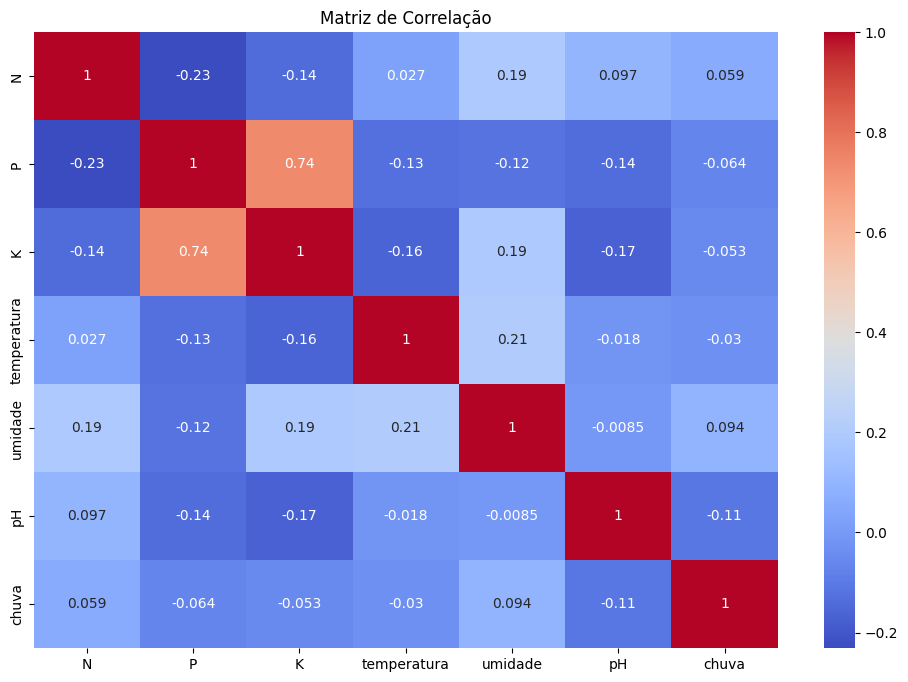

In [7]:
# Cria matriz de correlação
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=numerics).corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlação")
plt.show()

### Exploratory Data Analysis (EDA)

Análise exploratória com pelo menos 5 gráficos.

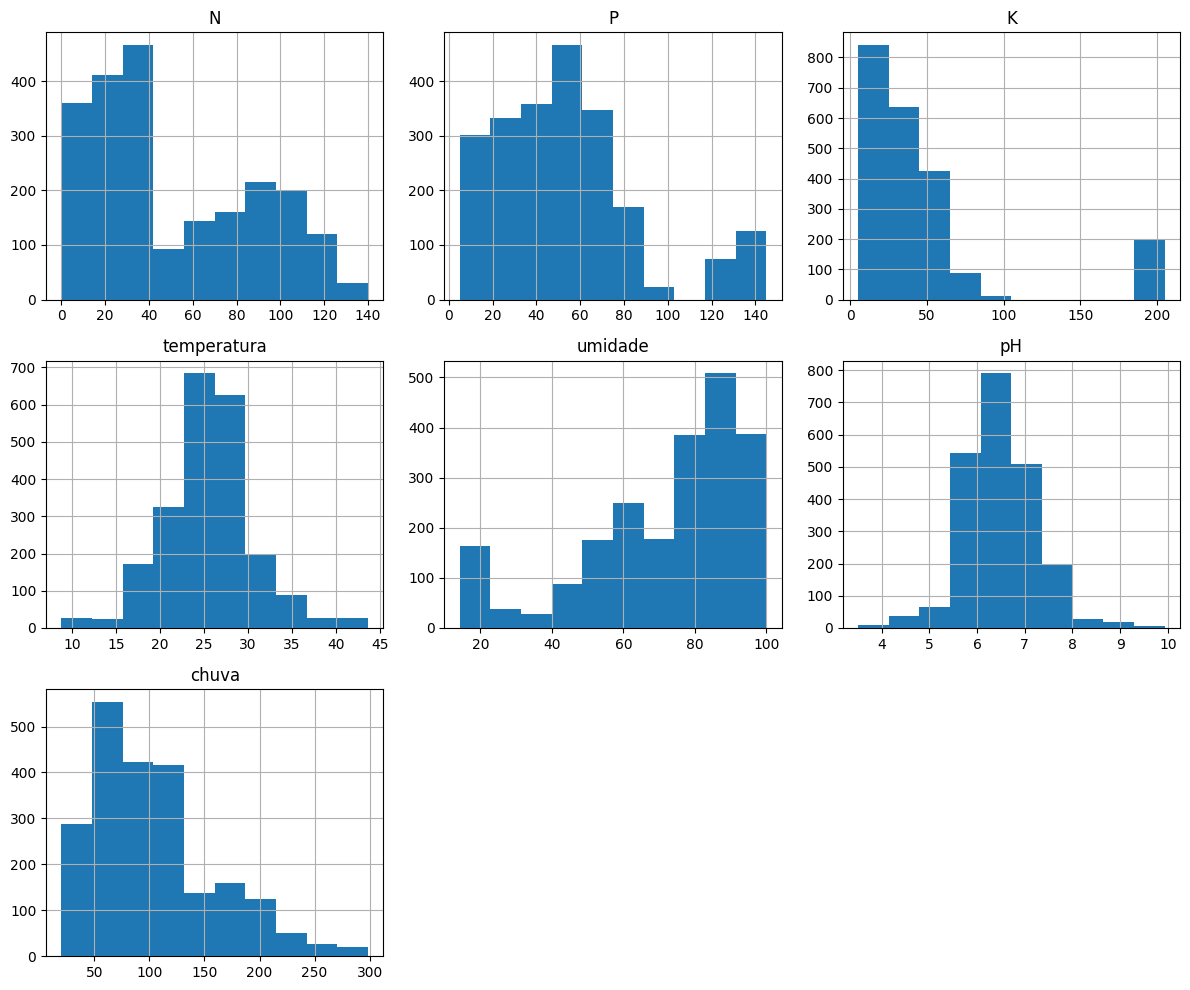

In [8]:
# Distribuição de cada feature
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

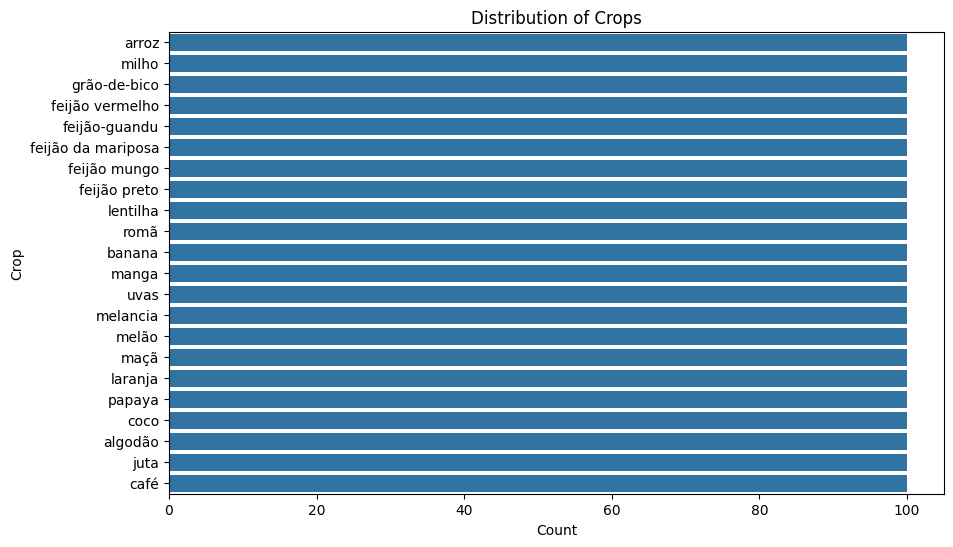

In [9]:
# Gráfico de contagem da coluna 'label' para visualizar a distribuição das culturas.
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='cultura')
plt.title('Distribution of Crops')
plt.xlabel('Count')
plt.ylabel('Crop')
plt.show()

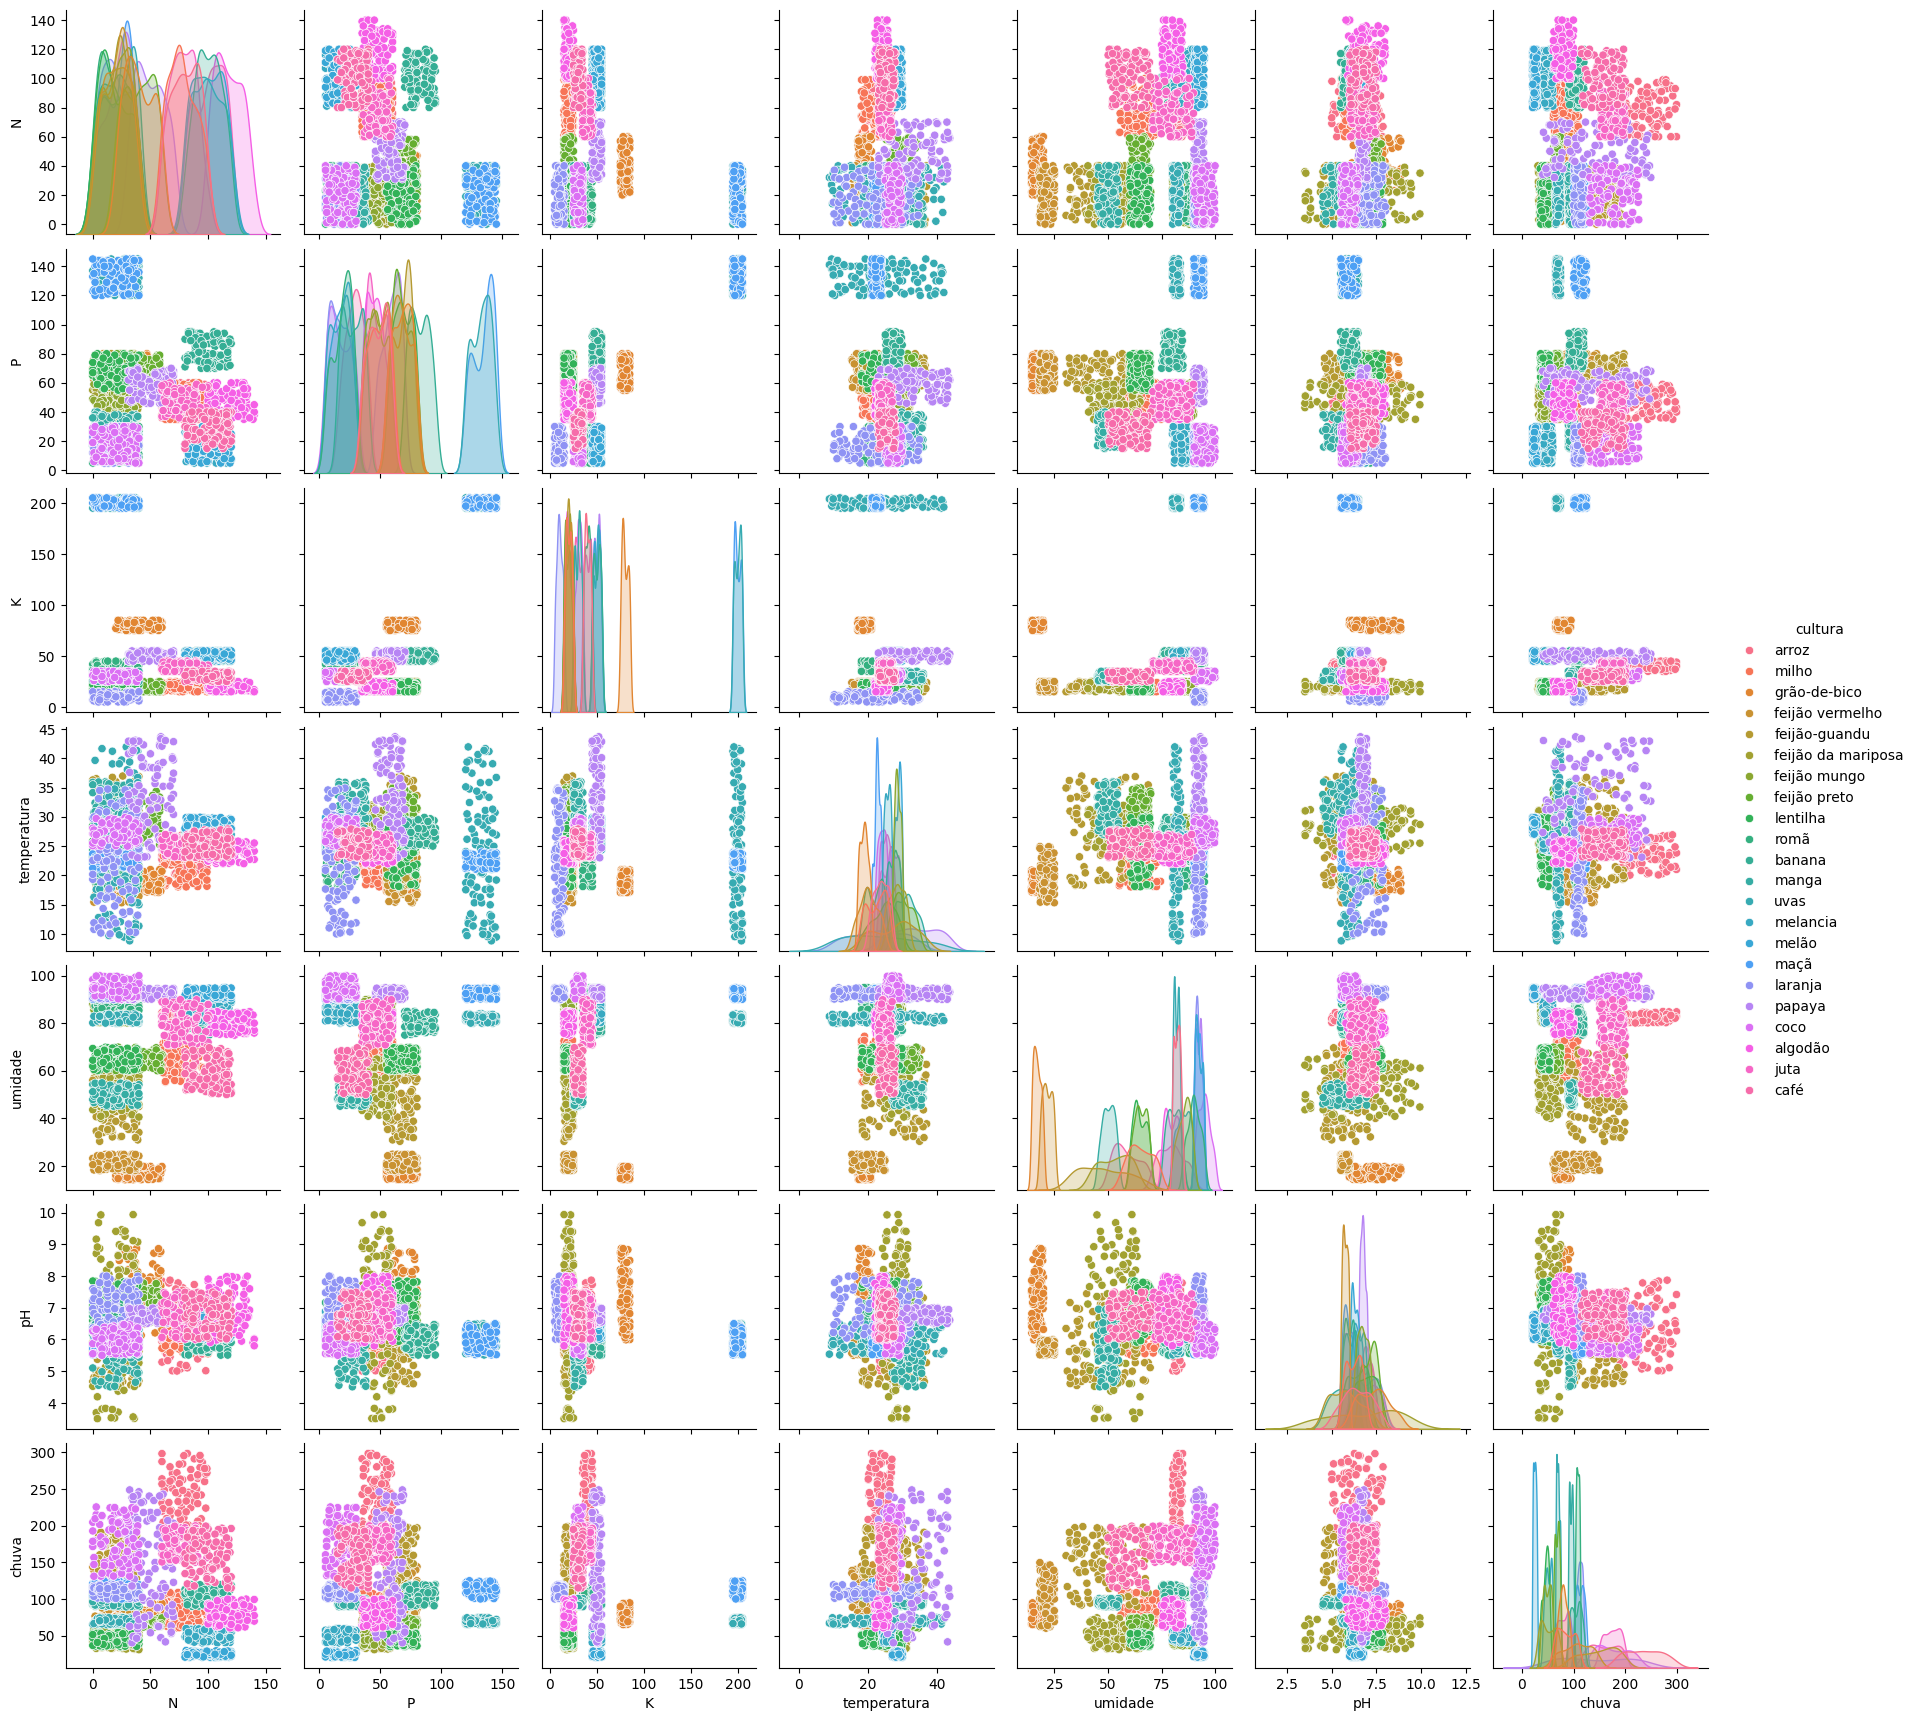

In [10]:
# Gráfico de pares (Pairplot) para visualizar as relações entre as variáveis numéricas.
sns.pairplot(df, hue='cultura')
plt.show()

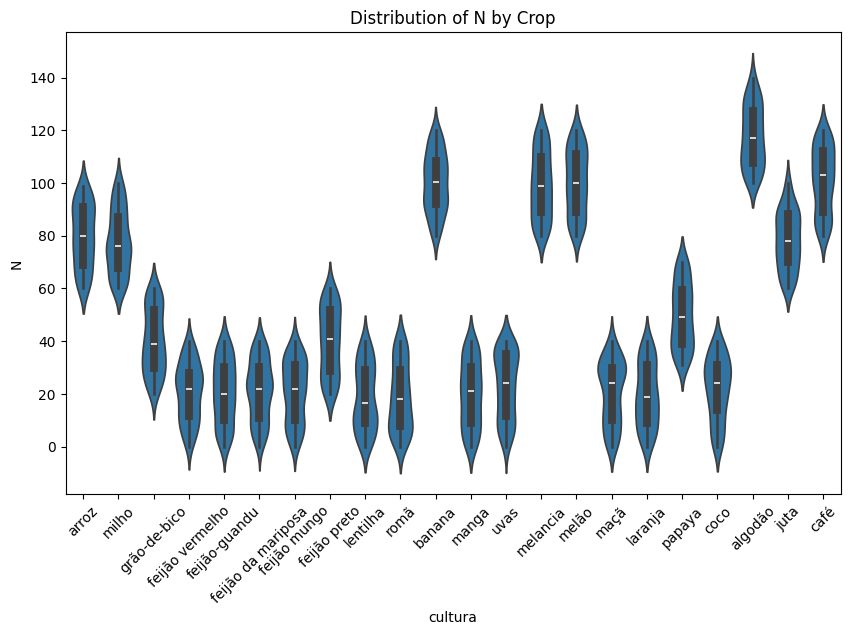

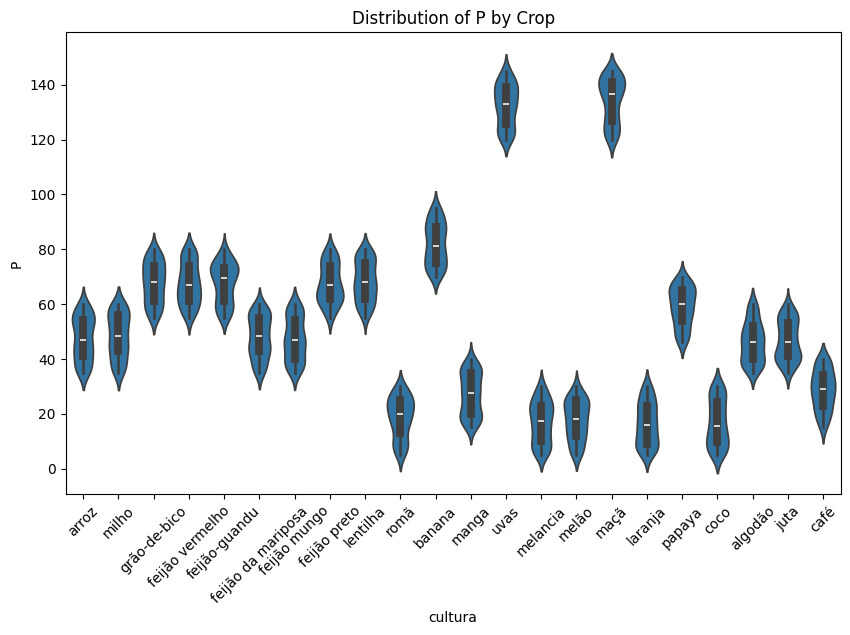

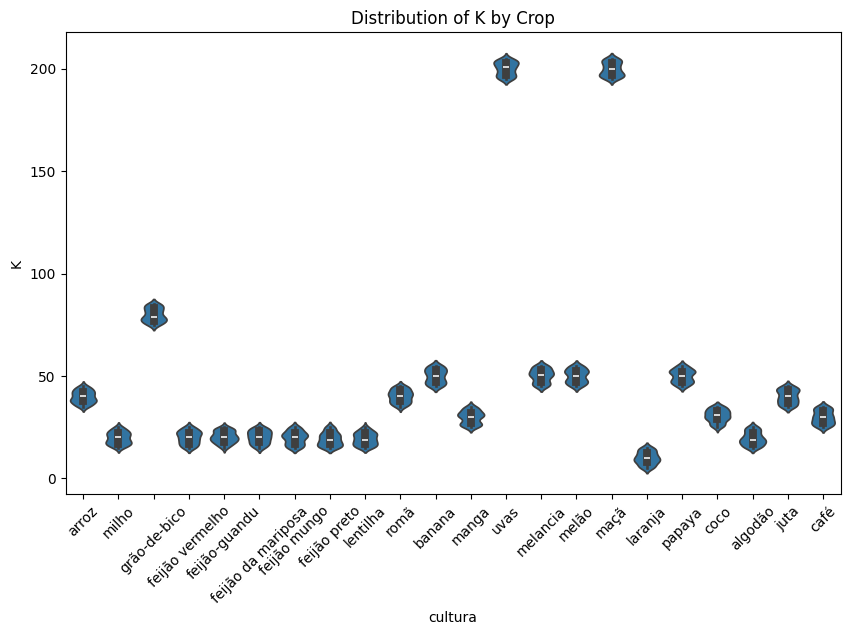

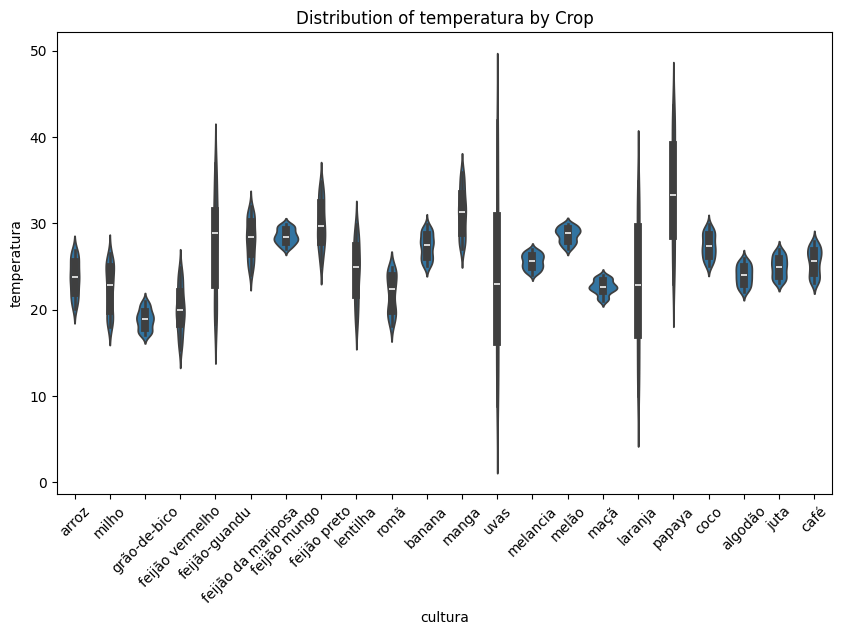

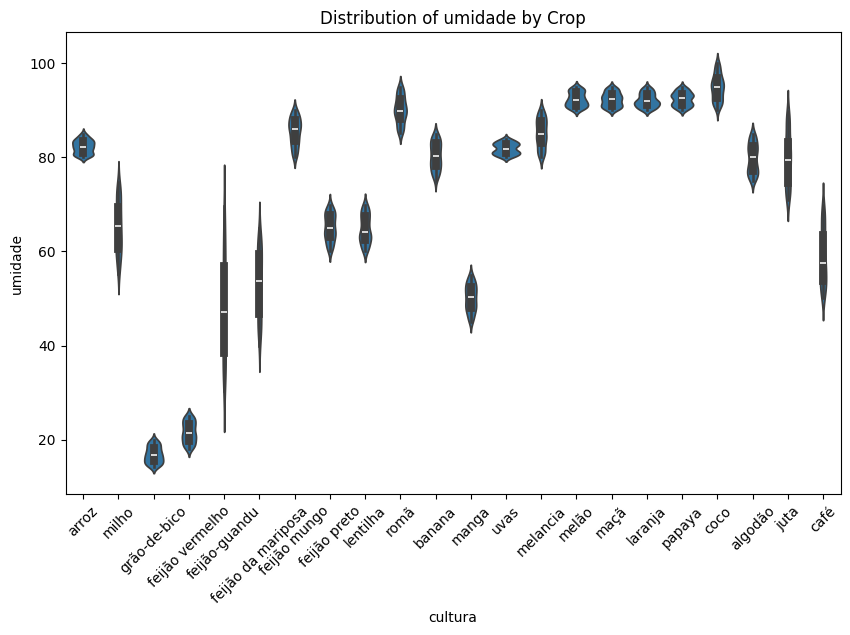

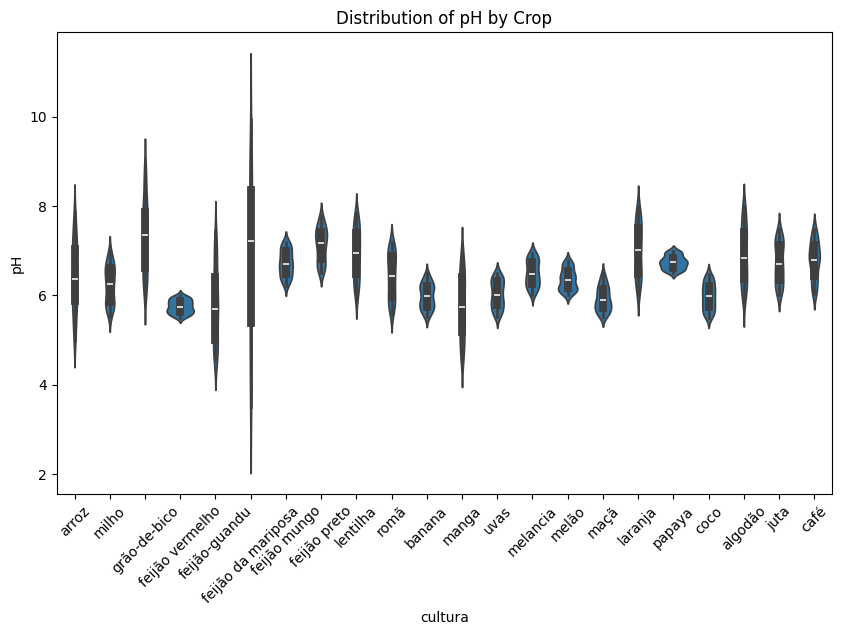

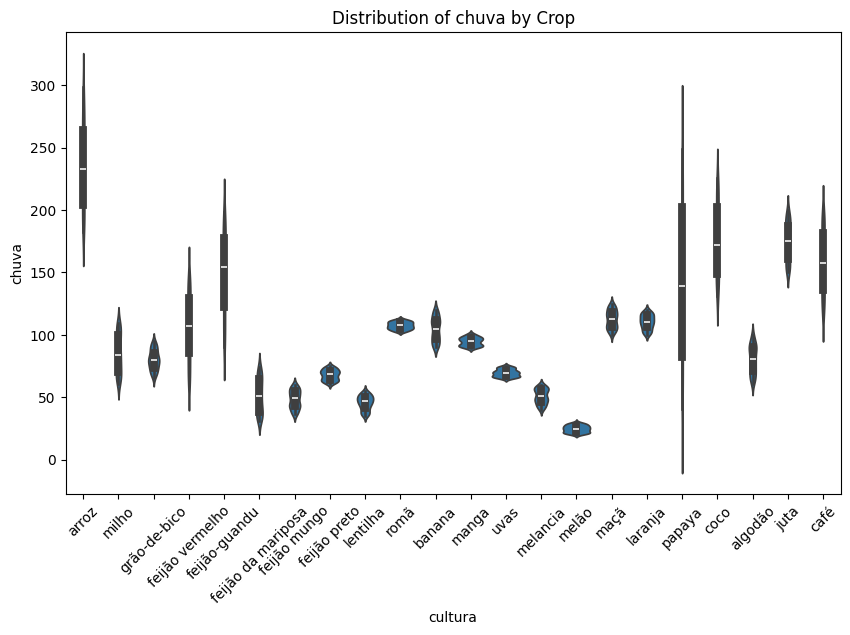

In [11]:
# Gráficos de violino (Violin plots) para visualizar a distribuição das variáveis numéricas por cultura.
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x='cultura', y=col)
    plt.title(f'Distribution of {col} by Crop')
    plt.xticks(rotation=45)
    plt.show()

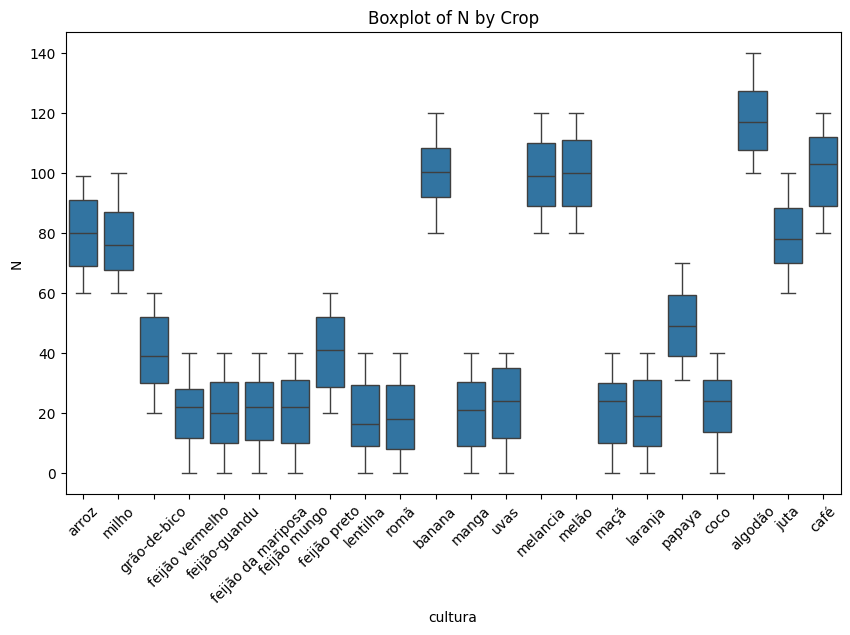

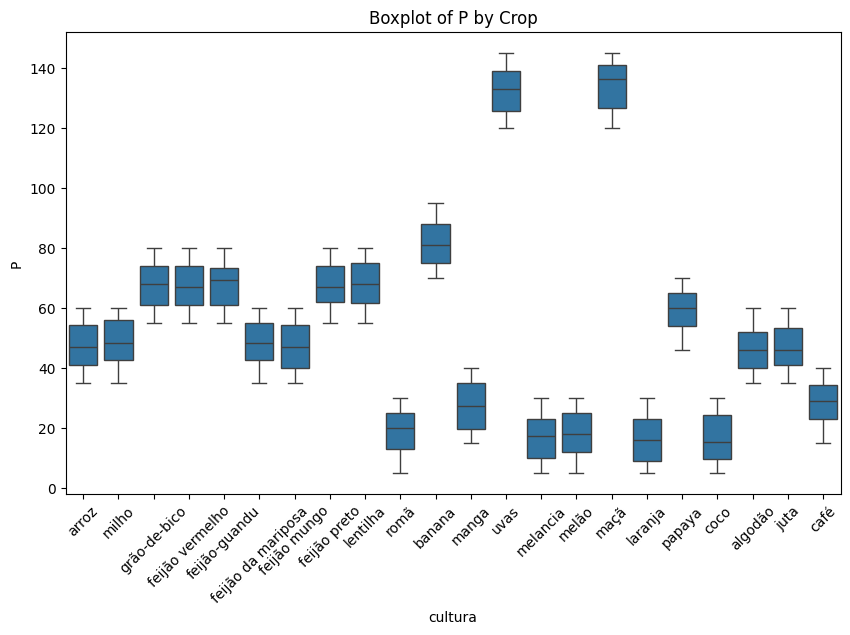

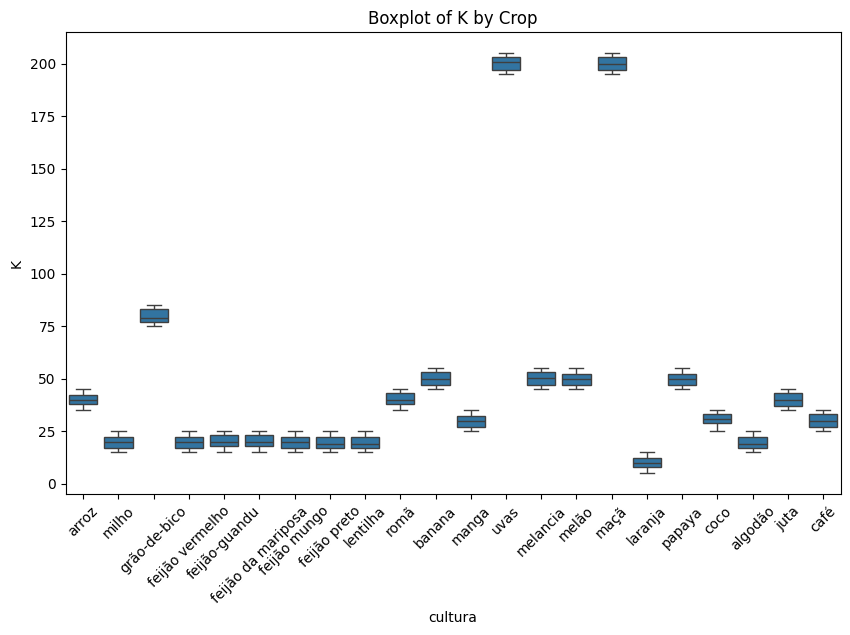

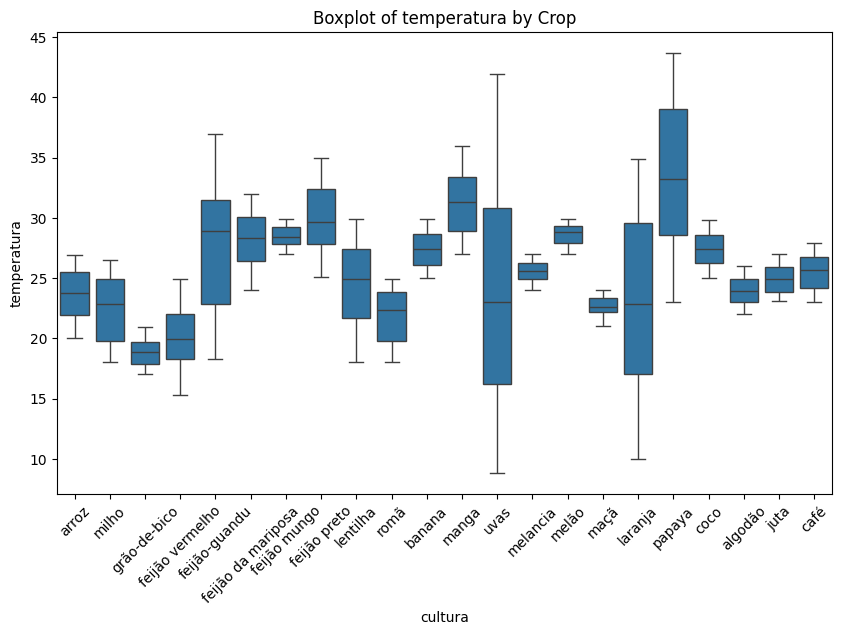

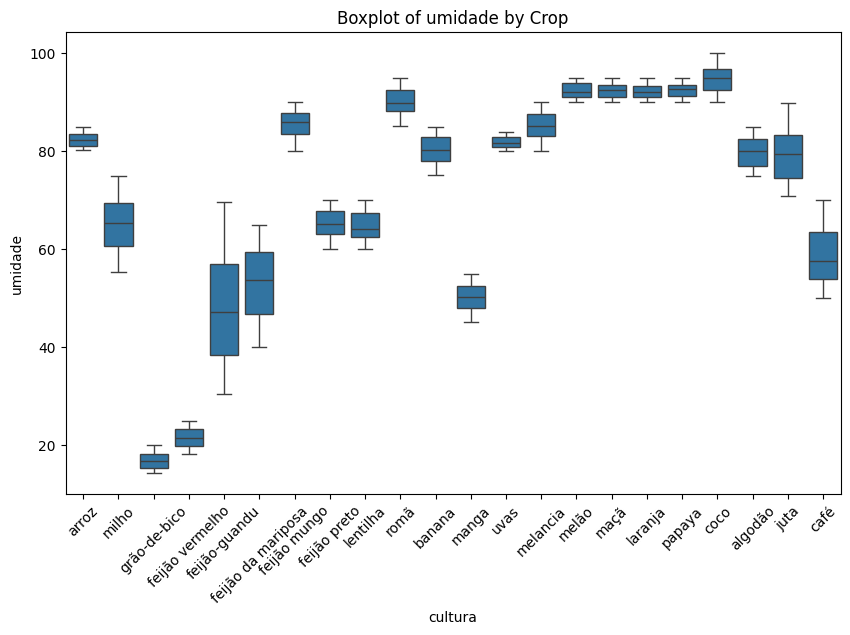

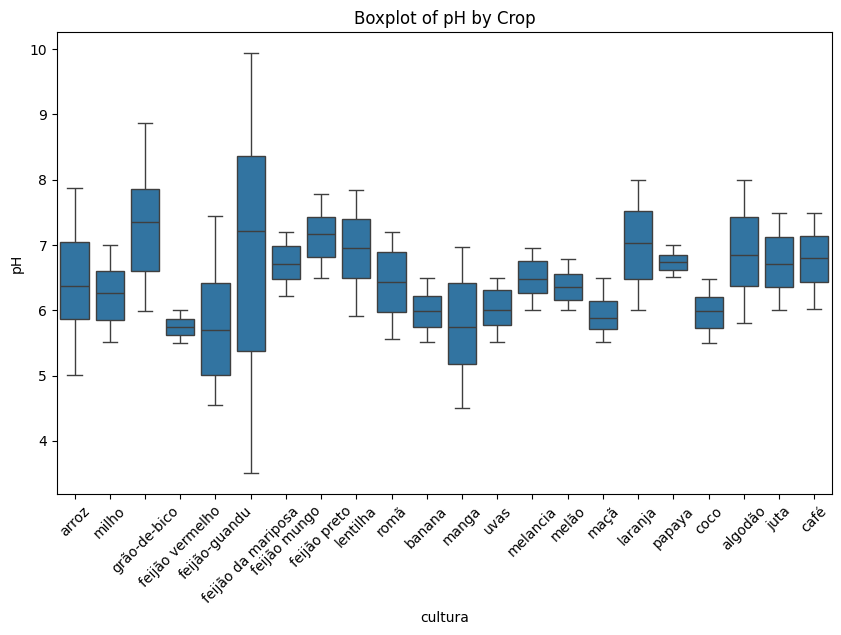

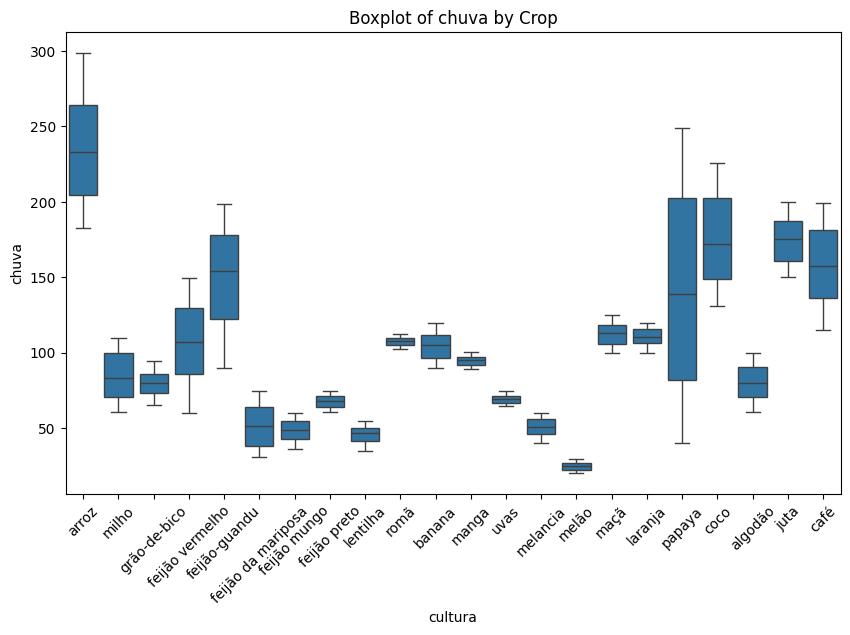

In [12]:
# Gráficos de caixa (Boxplots) para identificar possíveis valores atípicos e a distribuição das variáveis numéricas por cultura.
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='cultura', y=col)
    plt.title(f'Boxplot of {col} by Crop')
    plt.xticks(rotation=45)
    plt.show()

## Análise Descritiva e Principais Insights (EDA)

Esta seção resume os *insights* críticos obtidos através da Análise Exploratória de Dados (EDA) e das visualizações, que fundamentam as escolhas de pré-processamento e modelagem.

---

### 1 - Distribuição de Classes

A análise da variável-alvo (`cultura`) através do gráfico de contagem (Bar Plot) revela que a base de dados é **perfeitamente balanceada**:
* Existem **22 tipos de culturas distintas**.
* Cada cultura possui exatamente **100 observações**, totalizando 2200 entradas no conjunto de dados.

> **Implicação para ML:** Este balanceamento simplifica o treinamento e garante que a Métrica de Acurácia (`accuracy_score`) seja uma medida de desempenho **confiável**, pois não há viés em favor de classes majoritárias.

---

### 2 - Relações de Correlação Chave

O Heatmap de Correlação fornece *insights* cruciais sobre as interações entre as variáveis de solo e clima:

* **Potássio (K) e Fósforo (P):** Há uma **forte correlação positiva**, sugerindo que regiões com alto teor de um tendem a ter alto teor do outro.
* **Umidade e Temperatura:** Nota-se uma **correlação negativa significativa**, indicando que, em média, a temperatura tende a ser mais baixa onde a umidade é mais alta.
* **Precipitação e Umidade:** Demonstram uma **forte correlação positiva**, um achado esperado, pois maior precipitação eleva a umidade do ar.
* **Nitrogênio (N):** Apresenta **correlações fracas** com a maioria das outras variáveis, sugerindo que sua quantidade no solo é um fator relativamente independente (valioso para a separação de classes pelo modelo).

---

### 3 - Perfil de Precipitação e Variação de Outliers

A distribuição e os Boxplots revelam a natureza dos dados climáticos:

* **Distribuição de Chuva:** A Precipitação (`chuva`) apresenta **assimetria positiva** (cauda longa para a direita), indicando que a maioria das observações está concentrada em valores mais baixos, mas há ocorrência de chuvas extremas.
* **Outliers:** Os Boxplots identificam a presença de *outliers* notáveis nas variáveis **temperature, humidity e rainfall**.
    * **Implicação:** Esses valores extremos devem ser considerados, pois representam condições climáticas incomuns que podem ser importantes para certas culturas, mas também podem **introduzir ruído nos modelos** se não forem tratados adequadamente.

---

### 4 - Faixa de pH (Acidez/Alcalinidade)

A análise do pH do solo (`pH`) mostra uma ampla diversidade, crucial para a robustez do modelo:

* A **média do pH é de 6.47**, abrangendo solos ligeiramente ácidos a neutros.
* A variação total vai de um mínimo de **3.50** até um máximo de **9.94**, cobrindo uma ampla gama de solos (muito ácidos a muito alcalinos).

---

### 5 - Requisitos Extremos de Nutrientes (Média por Cultura)

A tabela de médias agrupadas por cultura destaca culturas com necessidades nutricionais extremas:

* **Altíssimo Potássio (K):** Culturas como **Uva (`uvas`)** e **Maçã (`maçã`)** são as mais exigentes, com os maiores valores médios de Potássio (em torno de 200 kg/ha).
* **Altíssimo Nitrogênio (N):** As culturas de **Juta (`juta`)** e **Café (`café`)** apresentam as maiores médias de Nitrogênio.
* **Baixo Nutriente:** Culturas de **Grão-de-Bico (`grão-de-bico`)** e **Lentilha (`lentilha`)** mostram-se as menos exigentes em NPK, indicando que podem ser cultivadas em solos com menor fertilidade.

## Identificando as condições ideais para as culturas

Vamos analisar os dados para determinar as condições ideais de solo e clima para diferentes culturas com base nas variáveis fornecidas. Podemos observar as estatísticas descritivas de cada cultura.

In [13]:
# Agrupar os dados por 'label' e calcular as estatísticas descritivas para as variáveis numéricas
crop_ideal_conditions = df.groupby('cultura')[numerical_cols].describe()
display(crop_ideal_conditions)

N                                                   \
                    count    mean        std    min     25%    50%     75%   
cultura                                                                      
algodão             100.0  117.77  11.628817  100.0  107.75  117.0  127.50   
arroz               100.0   79.89  11.917981   60.0   69.00   80.0   91.00   
banana              100.0  100.23  11.107241   80.0   92.00  100.5  108.25   
café                100.0  101.20  12.345203   80.0   89.00  103.0  112.00   
coco                100.0   21.98  11.761931    0.0   13.75   24.0   31.00   
feijão da mariposa  100.0   21.44  11.343418    0.0   11.00   22.0   30.25   
feijão mungo        100.0   20.99  11.510641    0.0   10.00   22.0   31.00   
feijão preto        100.0   40.02  12.664258   20.0   28.75   41.0   52.00   
feijão vermelho     100.0   20.75  10.834266    0.0   11.75   22.0   28.00   
feijão-guandu       100.0   20.73  11.849950    0.0   10.00   20.0   30.25   
grão-de-bico        100.0   40.09  12.150649   20.0   30.00   39.0   52.00   
juta                100.0   78.40  10.968274   60.0   70.00   78.0   88.25   
laranja             100.0   19.58  11.941930    0.0    9.00   19.0   31.00   
lentilha            100.0   18.77  12.196915    0.0    9.00   16.5   29.25   
manga               100.0   20.07  12.329037    0.0    9.00   21.0   30.25   
maçã                100.0   20.80  11.863704    0.0   10.00   24.0   30.00   
melancia            100.0   99.42  12.565127   80.0   89.00   99.0  110.00   
melão               100.0  100.32  12.176215   80.0   89.00  100.0  111.00   
milho               100.0   77.76  11.949490   60.0   67.75   76.0   87.00   
papaya              100.0   49.88  12.219607   31.0   39.00   49.0   59.25   
romã                100.0   18.87  12.617652    0.0    8.00   18.0   29.25   
uvas                100.0   23.18  12.466829    0.0   11.75   24.0   35.00   

                               P          ...        pH            chuva  \
                      max  count    mean  ...       75%       max  count   
cultura                                   ...                              
algodão             140.0  100.0   46.24  ...  7.426792  7.994680  100.0   
arroz                99.0  100.0   47.58  ...  7.039147  7.868475  100.0   
banana              120.0  100.0   82.01  ...  6.211092  6.490074  100.0   
café                120.0  100.0   28.74  ...  7.132105  7.493192  100.0   
coco                 40.0  100.0   16.93  ...  6.209201  6.470466  100.0   
feijão da mariposa   40.0  100.0   48.01  ...  8.366003  9.935091  100.0   
feijão mungo         40.0  100.0   47.28  ...  6.982101  7.199495  100.0   
feijão preto         60.0  100.0   67.47  ...  7.419390  7.775306  100.0   
feijão vermelho      40.0  100.0   67.54  ...  5.868351  5.998125  100.0   
feijão-guandu        40.0  100.0   67.73  ...  6.418984  7.445445  100.0   
grão-de-bico         60.0  100.0   67.79  ...  7.861625  8.868741  100.0   
juta                100.0  100.0   46.86  ...  7.126526  7.488014  100.0   
laranja              40.0  100.0   16.55  ...  7.517194  7.995849  100.0   
lentilha             40.0  100.0   68.36  ...  7.394295  7.841496  100.0   
manga                40.0  100.0   27.18  ...  6.416573  6.967418  100.0   
maçã                 40.0  100.0  134.22  ...  6.135616  6.499227  100.0   
melancia            120.0  100.0   17.00  ...  6.756902  6.956509  100.0   
melão               120.0  100.0   17.72  ...  6.550222  6.781050  100.0   
milho               100.0  100.0   48.44  ...  6.602366  6.995844  100.0   
papaya               70.0  100.0   59.05  ...  6.839783  6.993473  100.0   
romã                 40.0  100.0   18.75  ...  6.887951  7.199504  100.0   
uvas                 40.0  100.0  132.53  ...  6.313711  6.499605  100.0   

                                                                               \
                          mean        std         min         25%         50%   
cultura   

### Perfil Ideal de Solo (Média Geral do Dataset) / Seleção da culturas (Arroz , Maça e Uva)

In [14]:
##Código para Obter as Médias Estatísticas das Culturas Selecionadas

# 1. Obter o Perfil Ideal (Média Geral de todas as culturas)
perfil_ideal = df.drop(columns=['cultura']).mean().to_frame(name='Media Geral (Perfil Ideal)').T

# 2. Obter as médias das variáveis de solo e clima agrupadas por cultura (cultura)
medias_por_cultura = df.groupby('cultura')[['N', 'P', 'K', 'temperatura', 'umidade', 'pH', 'chuva']].mean()

# 3. Selecionar as culturas específicas para a análise comparativa
culturas_selecionadas = ['arroz', 'maçã', 'uvas']
comparacao_culturas = medias_por_cultura.loc[culturas_selecionadas]

# 4. Combinação e Formatação para Visualização do Relatório
tabela_comparativa_final = pd.concat([perfil_ideal, comparacao_culturas])

# Renomear o índice para clareza
tabela_comparativa_final.rename(index={'Media Geral (Perfil Ideal)': 'Ideal (Média)'}, inplace=True)

# Arredondar os valores para uma melhor apresentação no relatório
tabela_comparativa_final = tabela_comparativa_final.round(2)

# Exibir a tabela
print("--- Tabela de Médias (Perfil Ideal vs Culturas Selecionadas) ---")
print(tabela_comparativa_final)

--- Tabela de Médias (Perfil Ideal vs Culturas Selecionadas) ---
                   N       P       K  temperatura  umidade    pH   chuva
Ideal (Média)  50.55   53.36   48.15        25.62    71.48  6.47  103.46
arroz          79.89   47.58   39.87        23.69    82.27  6.43  236.18
maçã           20.80  134.22  199.89        22.63    92.33  5.93  112.65
uvas           23.18  132.53  200.11        23.85    81.88  6.03   69.61


## Desenvolvimento de Modelos Preditivos

Vamos preparar os dados e treinar 5 modelos de classificação diferentes para prever a cultura.

In [15]:
# Separar features (X) e target (y)
X = df.drop('cultura', axis=1)
y = df['cultura']

# Codificar a variável alvo
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalizar as features numéricas
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dados preparados para treinamento:")
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_test: {y_test.shape}")
print("\nFeatures numéricas normalizadas.")

Dados preparados para treinamento:
Shape de X_train: (1760, 7)
Shape de X_test: (440, 7)
Shape de y_train: (1760,)
Shape de y_test: (440,)

Features numéricas normalizadas.


### Treinamento e Avaliação dos Modelos Preditivos

#### 1. K-Nearest Neighbors

In [16]:
# K-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Acurácia do K-Nearest Neighbors: {accuracy_knn:.4f}")
print(f"Relatório de Classificação do K-Nearest Neighbors:\n{classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_)}")

Acurácia do K-Nearest Neighbors: 0.9682
Relatório de Classificação do K-Nearest Neighbors:
                    precision    recall  f1-score   support

           algodão       1.00      1.00      1.00        17
             arroz       0.93      0.74      0.82        19
            banana       1.00      1.00      1.00        21
              café       0.94      1.00      0.97        17
              coco       1.00      1.00      1.00        27
feijão da mariposa       1.00      0.88      0.93        24
      feijão mungo       1.00      1.00      1.00        19
      feijão preto       0.95      0.95      0.95        20
   feijão vermelho       0.91      1.00      0.95        20
     feijão-guandu       1.00      0.87      0.93        23
      grão-de-bico       1.00      1.00      1.00        26
              juta       0.81      0.91      0.86        23
           laranja       1.00      1.00      1.00        14
          lentilha       0.73      1.00      0.85        11
        

#### 2. Regressão Logística

In [17]:
# Regressão Logística
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Acurácia da Regressão Logística: {accuracy_lr:.4f}")
print(f"Relatório de Classificação da Regressão Logística:\n{classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_)}")

Acurácia da Regressão Logística: 0.9182
Relatório de Classificação da Regressão Logística:
                    precision    recall  f1-score   support

           algodão       0.94      1.00      0.97        17
             arroz       0.64      0.84      0.73        19
            banana       1.00      1.00      1.00        21
              café       0.94      1.00      0.97        17
              coco       1.00      1.00      1.00        27
feijão da mariposa       1.00      0.54      0.70        24
      feijão mungo       0.86      1.00      0.93        19
      feijão preto       0.89      0.85      0.87        20
   feijão vermelho       0.91      1.00      0.95        20
     feijão-guandu       1.00      0.78      0.88        23
      grão-de-bico       1.00      1.00      1.00        26
              juta       0.84      0.70      0.76        23
           laranja       1.00      1.00      1.00        14
          lentilha       0.69      1.00      0.81        11
        

#### 3. Support Vector Machine

In [18]:
# Support Vector Machine
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Acurácia da Support Vector Machine: {accuracy_svm:.4f}")
print(f"Relatório de Classificação da Support Vector Machine:\n{classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_)}")

Acurácia da Support Vector Machine: 0.9682
Relatório de Classificação da Support Vector Machine:
                    precision    recall  f1-score   support

           algodão       0.94      1.00      0.97        17
             arroz       1.00      0.74      0.85        19
            banana       1.00      1.00      1.00        21
              café       0.94      1.00      0.97        17
              coco       1.00      1.00      1.00        27
feijão da mariposa       1.00      0.88      0.93        24
      feijão mungo       1.00      1.00      1.00        19
      feijão preto       0.95      0.95      0.95        20
   feijão vermelho       0.91      1.00      0.95        20
     feijão-guandu       1.00      0.87      0.93        23
      grão-de-bico       1.00      1.00      1.00        26
              juta       0.81      0.96      0.88        23
           laranja       1.00      1.00      1.00        14
          lentilha       0.73      1.00      0.85        11
  

#### 4. Decision Tree

In [19]:
# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Acurácia da Decision Tree: {accuracy_dt:.4f}")
print(f"Relatório de Classificação da Decision Tree:\n{classification_report(y_test, y_pred_dt, target_names=label_encoder.classes_)}")

Acurácia da Decision Tree: 0.9841
Relatório de Classificação da Decision Tree:
                    precision    recall  f1-score   support

           algodão       1.00      1.00      1.00        17
             arroz       0.85      0.89      0.87        19
            banana       1.00      1.00      1.00        21
              café       1.00      1.00      1.00        17
              coco       1.00      1.00      1.00        27
feijão da mariposa       1.00      0.92      0.96        24
      feijão mungo       1.00      1.00      1.00        19
      feijão preto       0.95      1.00      0.98        20
   feijão vermelho       1.00      1.00      1.00        20
     feijão-guandu       1.00      1.00      1.00        23
      grão-de-bico       1.00      1.00      1.00        26
              juta       0.91      0.87      0.89        23
           laranja       1.00      1.00      1.00        14
          lentilha       0.92      1.00      0.96        11
             manga  

#### 5. Random Forest

In [20]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia da Random Forest: {accuracy_rf:.4f}")
print(f"Relatório de Classificação da Random Forest:\n{classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_)}")

Acurácia da Random Forest: 0.9932
Relatório de Classificação da Random Forest:
                    precision    recall  f1-score   support

           algodão       1.00      1.00      1.00        17
             arroz       1.00      0.89      0.94        19
            banana       1.00      1.00      1.00        21
              café       1.00      1.00      1.00        17
              coco       1.00      1.00      1.00        27
feijão da mariposa       1.00      0.96      0.98        24
      feijão mungo       1.00      1.00      1.00        19
      feijão preto       1.00      1.00      1.00        20
   feijão vermelho       1.00      1.00      1.00        20
     feijão-guandu       1.00      1.00      1.00        23
      grão-de-bico       1.00      1.00      1.00        26
              juta       0.92      1.00      0.96        23
           laranja       1.00      1.00      1.00        14
          lentilha       0.92      1.00      0.96        11
             manga  

### Avaliação Comparativa dos Modelos

Vamos comparar a acurácia de cada modelo treinado:

Acurácia dos Modelos:
K-Nearest Neighbors: 0.9682
Regressão Logística: 0.9182
Support Vector Machine: 0.9682
Decision Tree: 0.9841
Random Forest: 0.9932


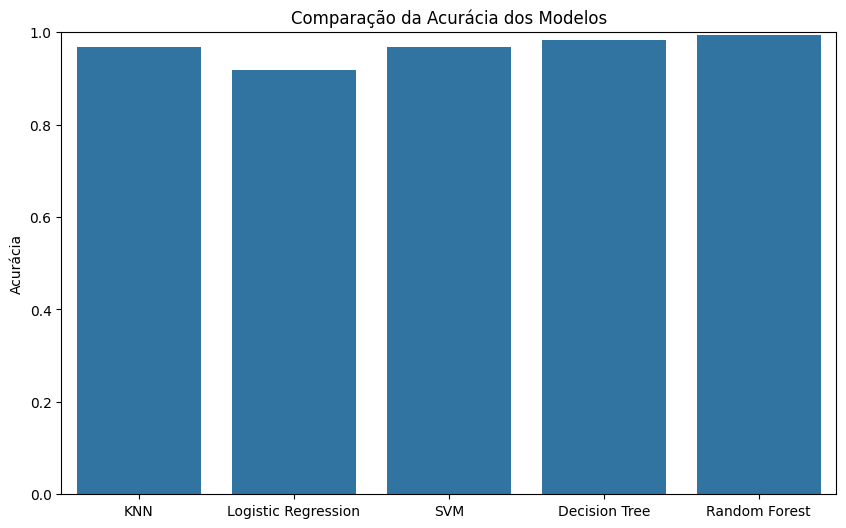

In [21]:
print("Acurácia dos Modelos:")
print(f"K-Nearest Neighbors: {accuracy_knn:.4f}")
print(f"Regressão Logística: {accuracy_lr:.4f}")
print(f"Support Vector Machine: {accuracy_svm:.4f}")
print(f"Decision Tree: {accuracy_dt:.4f}")
print(f"Random Forest: {accuracy_rf:.4f}")

# Optionally, create a bar plot to visualize the accuracies
model_accuracies = {
    'KNN': accuracy_knn,
    'Logistic Regression': accuracy_lr,
    'SVM': accuracy_svm,
    'Decision Tree': accuracy_dt,
    'Random Forest': accuracy_rf
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()))
plt.title('Comparação da Acurácia dos Modelos')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
plt.show()

### Comparando Modelos com Curvas ROC

Vamos gerar Curvas ROC para comparar visualmente o desempenho dos modelos de classificação.

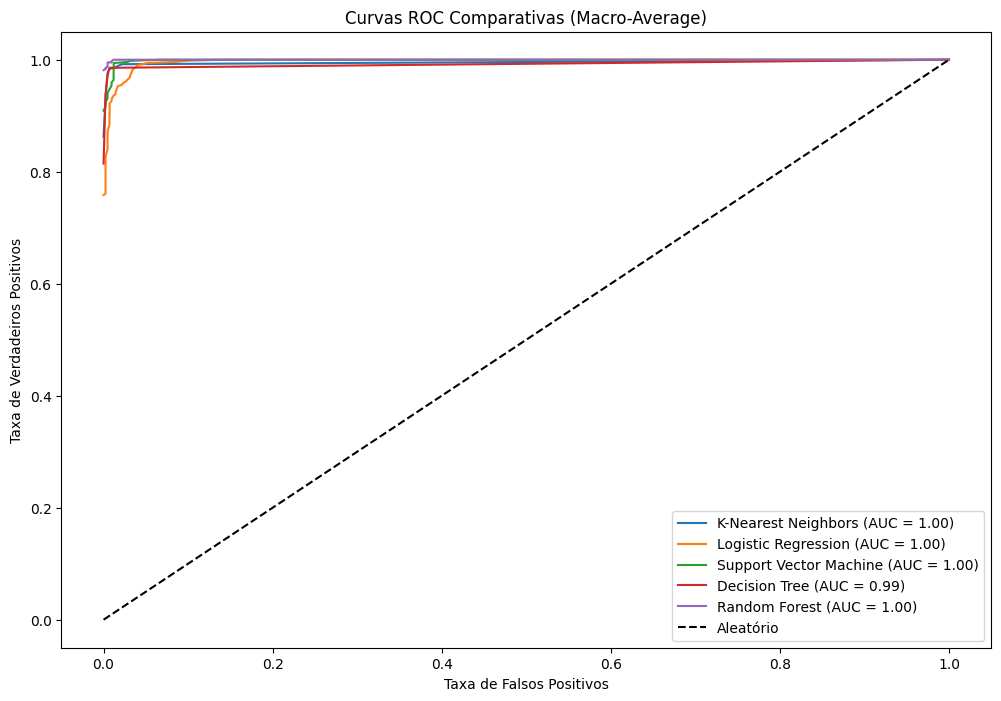

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarizar a variável alvo para calcular a Curva ROC para cada classe
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(12, 8))

# Dicionário para armazenar os modelos
models = {
    'K-Nearest Neighbors': knn_model,
    'Logistic Regression': lr_model,
    'Support Vector Machine': svm_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test_scaled)
    else:
        continue

    # Calcular a Curva ROC e a Área sob a Curva (AUC) para cada classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotar a Curva ROC média (macro-average)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'{name} (AUC = {roc_auc["macro"]:.2f})')


plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC Comparativas (Macro-Average)')
plt.legend()
plt.show()